<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250102%5D%20FL-DL%20MLP-CNN%20on%20WSN-DS%20with%20L2%3D0.01%20%26%20Dropout%3D0.2%20%26%2050%20epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FL-DL // MLP-CNN model 5 classes on WSN-DS with L2=0.01 & Dropout=0.2 & with 50 Epochs**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv") #5 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**Hybrid MLP-CNN with L2=0.01 & Dropout=0.2 & With 50 Epochs**

In [ ]:
from keras.layers import Dense, Dropout, Reshape, Conv1D
from keras.regularizers import l2
from keras.layers import Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=5)  # Change to 5 classes
y_test = to_categorical(y_test, num_classes=5)

# Define the hybrid MLP + CNN model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Reshape output for CNN layer
    model.add(Reshape((64, 1)))  # Reshape to (batch_size, timesteps=64, features=1)

    # CNN layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the model with early stopping
#from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Before fitting the model, ensure y_train and y_test have the correct shape:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
assert y_train.shape[1:] == (5,), "y_train shape incorrect"
assert y_test.shape[1:] == (5,), "y_test shape incorrect"

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    #callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


y_train shape: (1360264, 5)
y_test shape: (340066, 5)
Epoch 1/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.8910 - loss: 0.3571 - val_accuracy: 0.9030 - val_loss: 0.2482
Epoch 2/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.8987 - loss: 0.2623 - val_accuracy: 0.9024 - val_loss: 0.2416
Epoch 3/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.8986 - loss: 0.2625 - val_accuracy: 0.9036 - val_loss: 0.2439
Epoch 4/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 207s 5ms/step - accuracy: 0.8980 - loss: 0.2636 - val_accuracy: 0.9036 - val_loss: 0.2368
Epoch 5/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.8983 - loss: 0.2643 - val_accuracy: 0.9018 - val_loss: 0.2459
Epoch 6/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 212s 5ms/step - accuracy: 0.8981 - loss: 0.2631 - val_accuracy: 0.9033 - val_loss: 0.2460
Epoch 7/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.8981 - loss: 0.2634 - val_accuracy: 0.9031 - val_loss: 0.2405
Epoch 8/

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9026071410
Precision: 0.9226132410
Recall: 0.9026071410
F1-Score: 0.8994867945


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

10628/10628 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
Accuracy: 0.9026071410
Precision: 0.9226132410
Recall: 0.9026071410
F1-Score: 0.8994867945


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[66425  1364     4   133    87]
 [    0 41055 26938    20     0]
 [    0     9 67988    16     0]
 [ 4225   291    16 63482     0]
 [    7    10     0     0 67996]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.97665152 0.6036346  0.99963242 0.93336666 0.99975005]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-36-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9889428728
Class 1: 0.9677464467
Class 2: 0.9713867281
Class 3: 0.9899974254
Class 4: 0.9998881367

Macro-average AUC: 0.9835923219


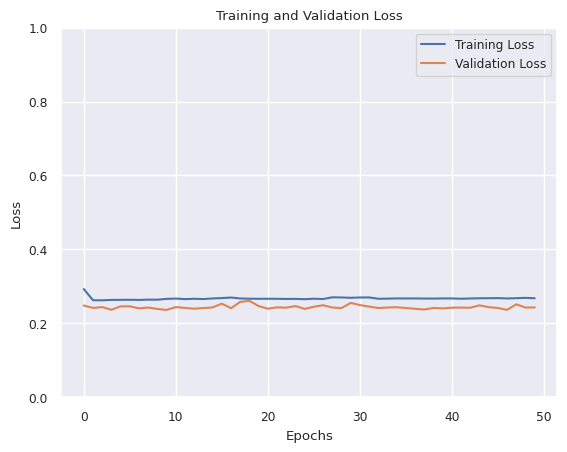

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid MLP-CNN Model


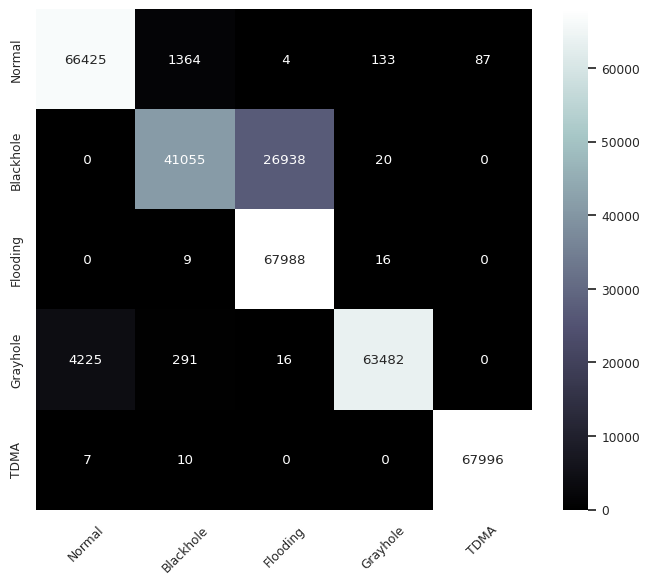

In [ ]:
print("Confusion Matrix of Hybrid MLP-CNN Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
plt.yticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'],
            yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-CNN Model


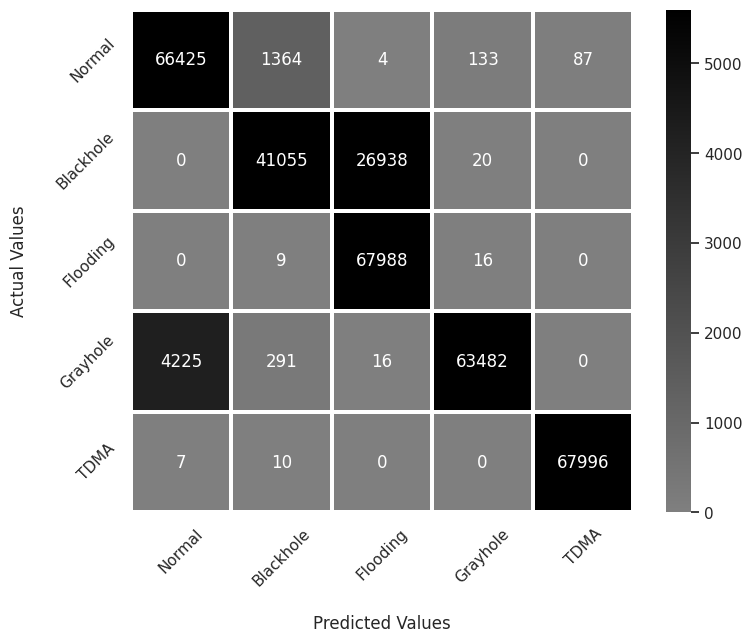

In [ ]:
print("Confusion Matrix of Federated DL// MLP-CNN Model")
conf_mat(y_true_classes, y_pred_classes)